In [12]:
# You can set your own compiled m2aia libraries by adding M2AIA_PATH
# import os
# os.environ["M2AIA_PATH"] = "/home/jtfc/HS/M2aia/m2aia-dev/m2aia-release/MITK-build/lib/"
import m2aia as m2
import numpy as np

In [13]:

# download the example files if required
# for all examples continuos profile data are used
from download_helper import DownloadMTBLS2639
# if wanted, you can replace the file_names list with data on your disk
# e.g. filenames = ["my/files/location/data.imzML", "..."]
file_names = DownloadMTBLS2639(selection=[2]) # only slice 3 is selected, you choose fom [0,1,2,3]


Example III - Ion-Images
----------------------------------------------

In this example we are going to explore how to work with ion and other images. To do so, we will:

1) load an imzML MSI dataset
2) Set the pooling (reduce function) and query some ion images
3) Combine multiple ion images to a RGB image, ready for publication
4) Mask ion images to create a spatial segmentation using a simple thresholding function
5) Use the index and mask images to create overview spectra for the masked regions

In [14]:
# initialize the image
# set normalization to RMS
I = m2.ImzMLReader(str(file_names[0]), normalization=m2.m2NormalizationRMS)

[61.785] [imzML]: data/150429_ew_section2_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 220x171x1
	[num spectra]: 26744
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
	[normalization]: RMS


How to save Ion-Images for further processing?
-----------------------------------------------

1) GetArray(mz, tol) will generate a numpy array, loosing all real world information like the origin, spacing or direction of the image.
2) GetImage(mz, tol) will generate a itkImage, that holds those real world information. 

If ion images are produced for further analysis pipelines, it is recommended to use the GetImage 
method and save the images as .nrrd files [1], using SimpleITK [2]. This will keep the physical 
properties (i.e. pixel size) of an image. E.g.: sitk.WriteImage(I.GetImage(mz,tol), path/to/file.nrrd)

All images are exported as 3D images, even if it is only one slice. For visualization we have to 
squeeze the 3rd dimension, i.e.: ```np.squeeze(I.GetArray(1088.868, 0.25))``` or ```I.GetArray(1088.868, 0.25)[0]```

[1] http://teem.sourceforge.net/nrrd/format.html<br/>
[2] https://simpleitk.org/

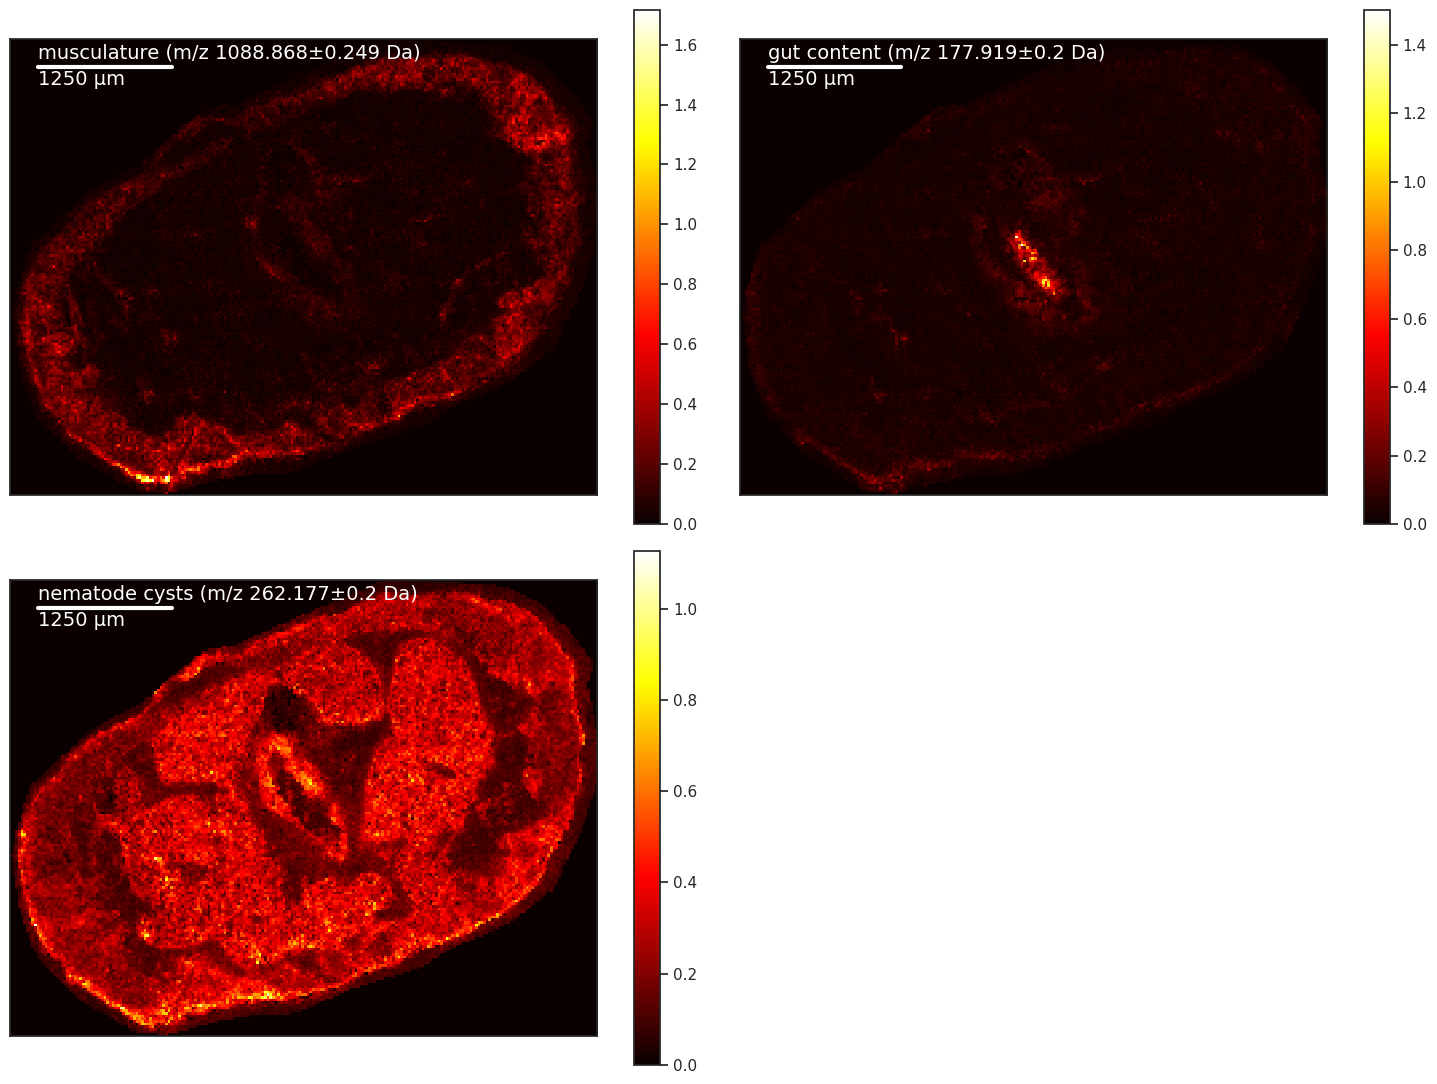

In [23]:
from Example_III_Helpers import showimg
# set the pooling function
I.SetPooling(m2.m2PoolingMean)

# get the spacing for the size indicator
s = I.GetSpacing()

# Get ion images and convert it to 2D slices
MUSC = I.GetArray(1088.868, 0.25)
CONT = I.GetArray(177.919, 0.25)
NEMA = I.GetArray(262.177, 0.25)

fig,ax = showimg(MUSC[0], cmap='hot', title='musculature (m/z 1088.868±0.249 Da)'   ,spacing=s, subplot_pos=(2,2,1), size=(15,11))
fig,ax = showimg(CONT[0], cmap='hot', title='gut content (m/z 177.919±0.2 Da)'      ,spacing=s, subplot_pos=(2,2,2), fig=fig)
fig,ax = showimg(NEMA[0], cmap='hot', title='nematode cysts (m/z 262.177±0.2 Da)'   ,spacing=s, subplot_pos=(2,2,3), fig=fig)
fig.tight_layout()


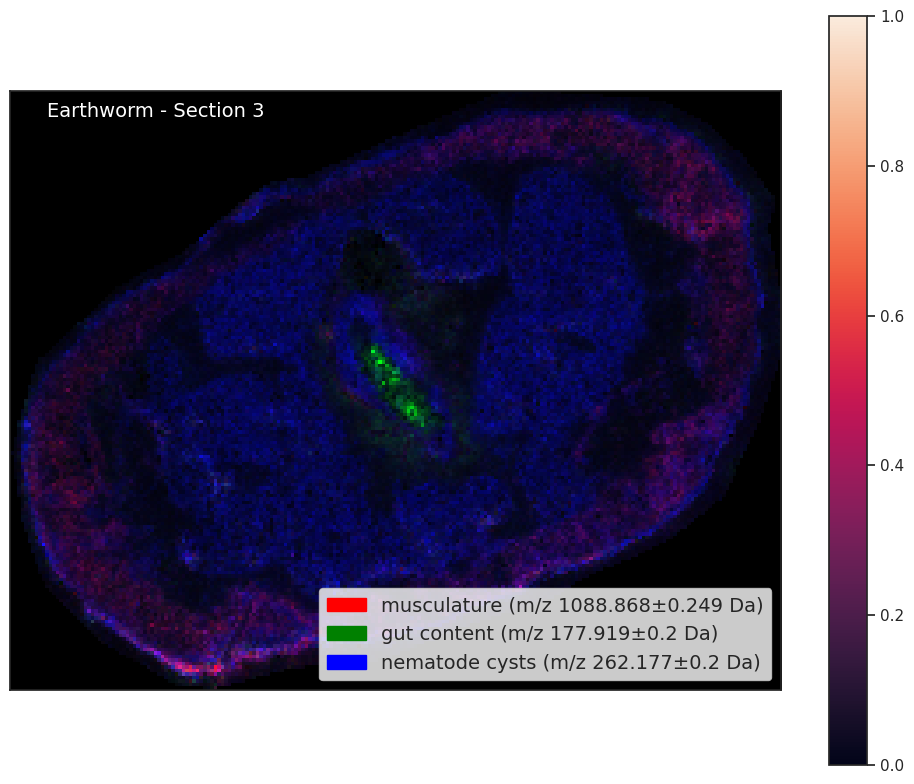

In [21]:
import matplotlib.patches as mpatches

# stack the images to create a three channel RGB image
RGB = np.vstack([MUSC,CONT,NEMA])
# (3, 171, 220) [Channels, Height, Width]

# channel-wise rescale intensities to values between 0 and 1
for i in range(3):
    RGB[i] = (RGB[i]-np.min(RGB[i]))/((np.max(RGB[i])-np.min(RGB[i]))) # map to interval [0,1]

# permute dimensions to get a valid RGB image shape
# After (171, 220, 3) [Height, Width, Channels]
RGB = np.moveaxis(RGB, [0],[2])

# show the image
fig, ax = showimg(RGB, title='Earthworm - Section 3', size=(10,8))
fig.tight_layout()

# add a legend
red_patch = mpatches.Patch(color='red', label='musculature (m/z 1088.868±0.249 Da)')
ax.legend(handles=[red_patch])
green_patch = mpatches.Patch(color='green', label='gut content (m/z 177.919±0.2 Da)')
ax.legend(handles=[red_patch])
blue_patch = mpatches.Patch(color='blue', label='nematode cysts (m/z 262.177±0.2 Da)')
ax.legend(handles=[red_patch])
leg = ax.legend(handles = [red_patch, green_patch, blue_patch],loc='lower right', fontsize=14)

Access normalization, index and mask images
-------------------------------------------

Different additional images artifacts exist which can be very helpful to access spectra, regions, etc.

- The normalization images store the normalization values for each pixel/spectrum.
- The mask image is a binary mask indicating regions of valid spectra.
- The index image represents the spectrum indices used in the imzML (starting by one).

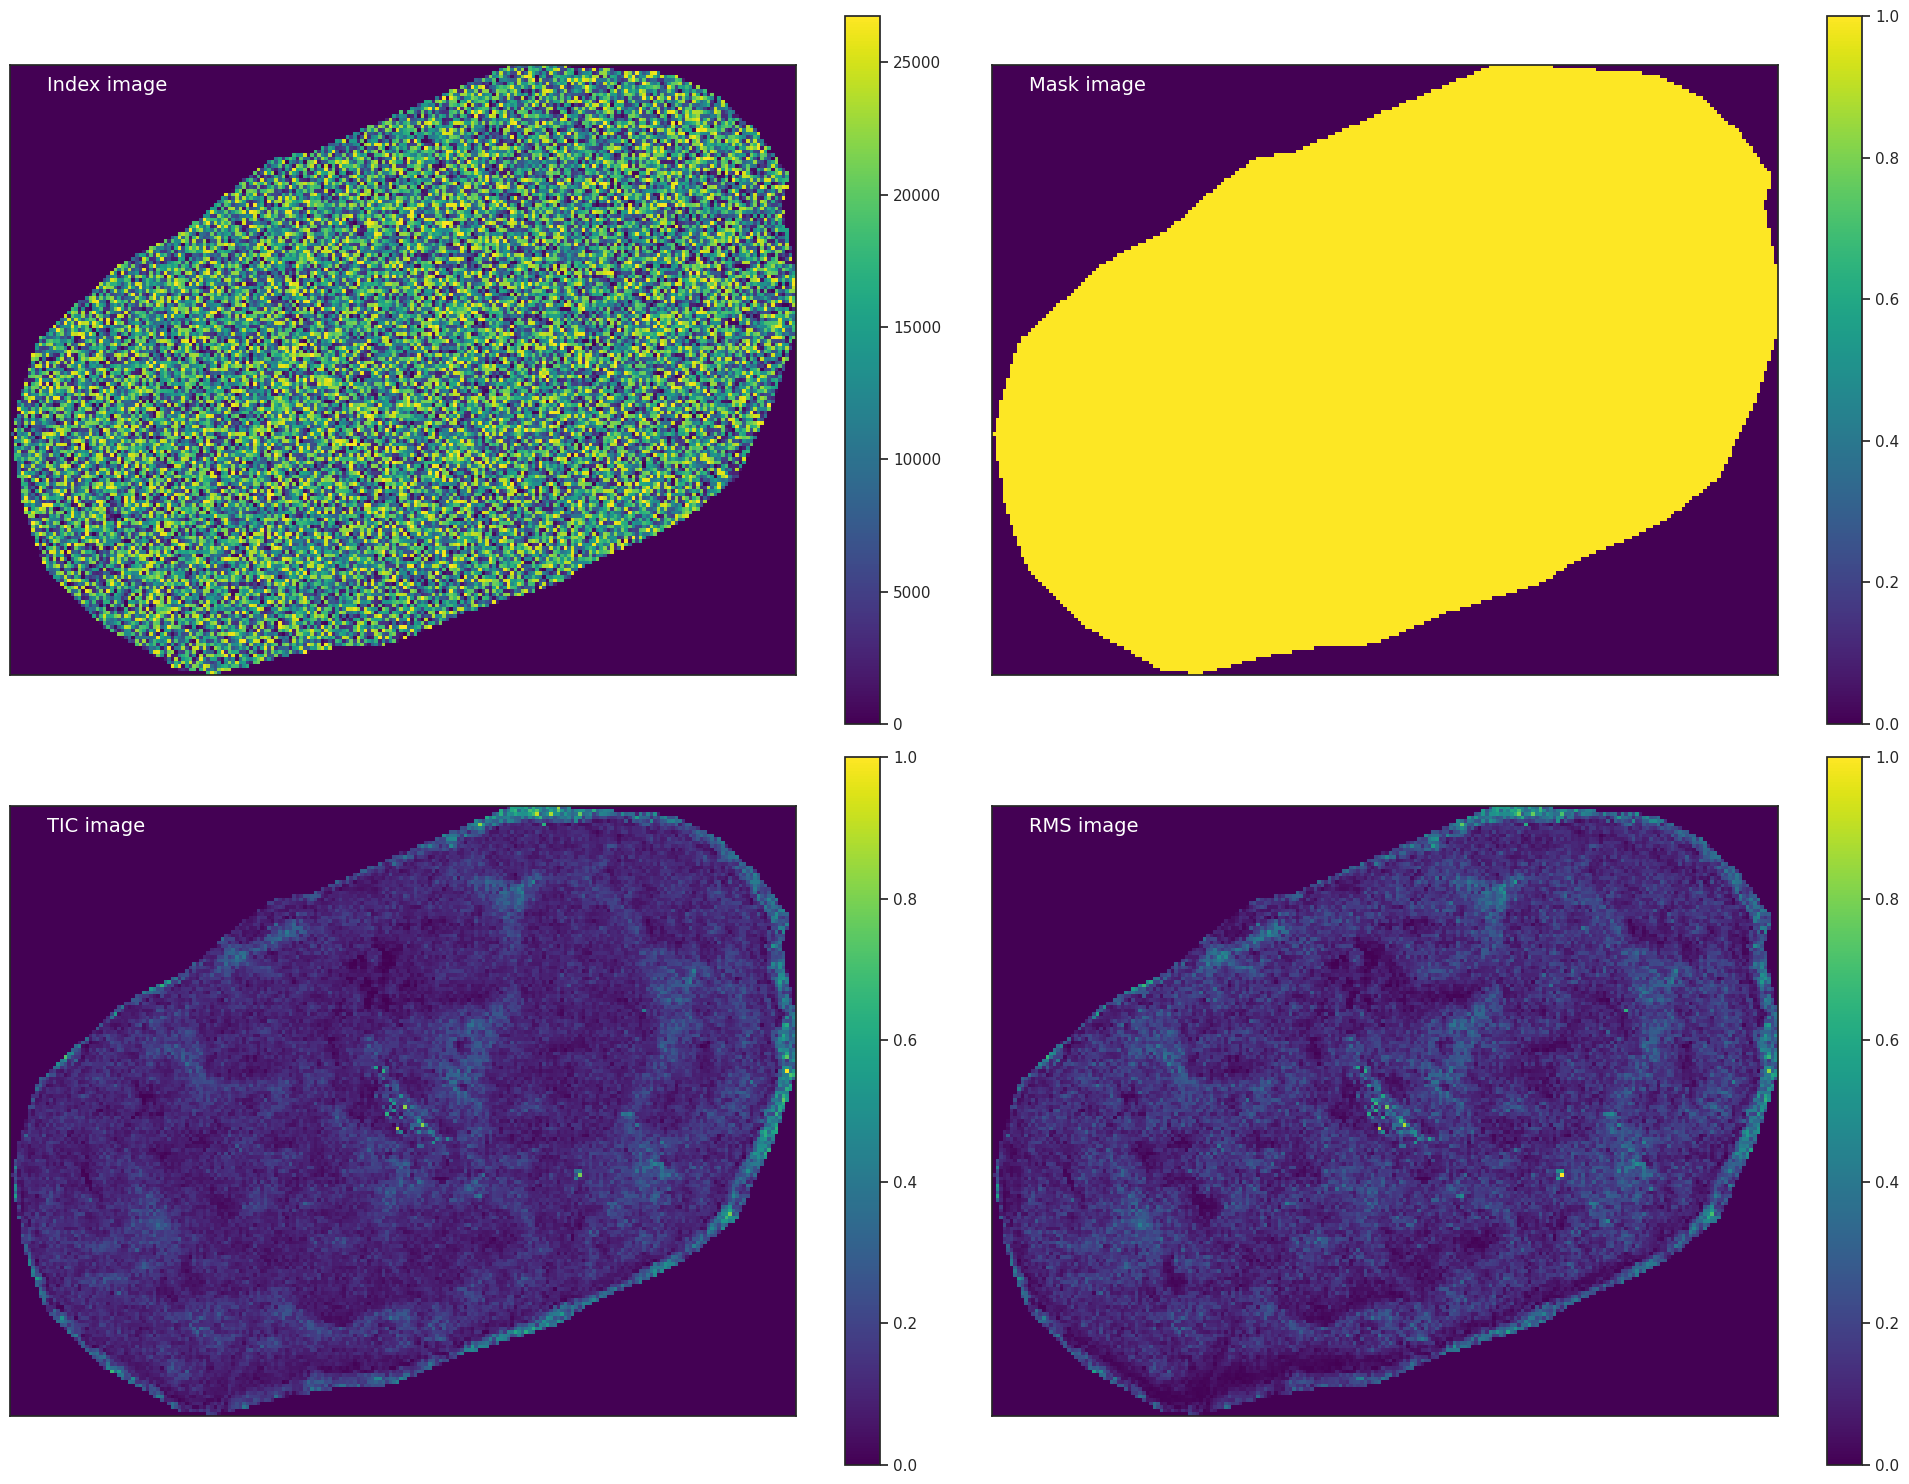

In [25]:
TIC = I.GetNormalizationArray(m2.m2NormalizationTIC)
RMS = I.GetNormalizationArray(m2.m2NormalizationRMS)
IDX = I.GetIndexArray()
MASK = I.GetMaskArray()

def MinMaxNorm(img, rel_max=None):
    tmp = (img-np.min(img))/(np.max(img)-np.min(img))
    if rel_max is not None:
        return np.clip(tmp/rel_max, a_min=0, a_max=rel_max)
    return tmp

fig,_ = showimg(             IDX[0],  cmap='viridis', title='Index image', subplot_pos=(2,2,1), size=(20,15))
showimg(                    MASK[0],  cmap='viridis', title='Mask image',  subplot_pos=(2,2,2), fig=fig)
showimg(         MinMaxNorm(TIC)[0],  cmap='viridis', title='TIC image',   subplot_pos=(2,2,3), fig=fig)
showimg(         MinMaxNorm(RMS)[0],  cmap='viridis', title='RMS image',   subplot_pos=(2,2,4), fig=fig)
fig.tight_layout()

Working with mask and indices images
------------------------------------

For demonstration of the masking process we choose a threshold value to create a mask based on the intensity values of an ion image. We follow these steps:

1) MinMax normalization of the image
2) Set a threshold (values are chosen only for this demonstration)
3) Apply morphological operations to improve the segmentation quality
4) Get the indices for the created mask/segmentation images
5) Use the indices to read the spectra from disk

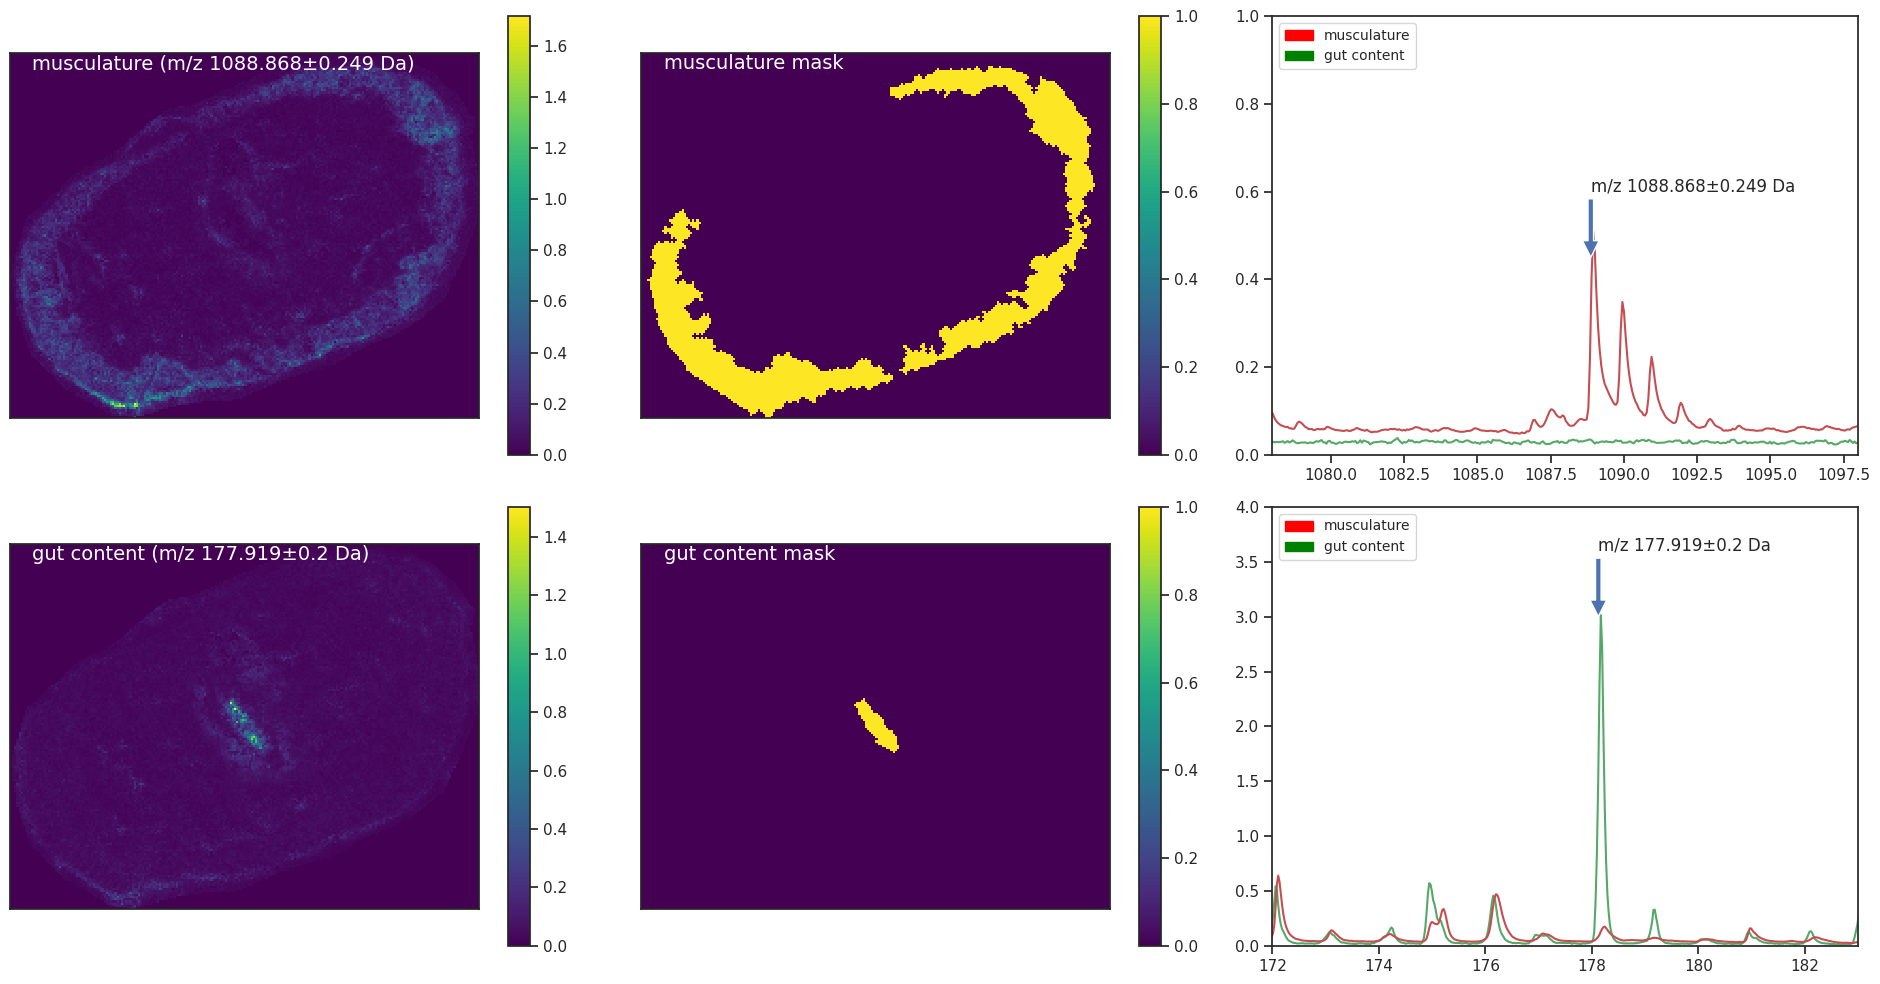

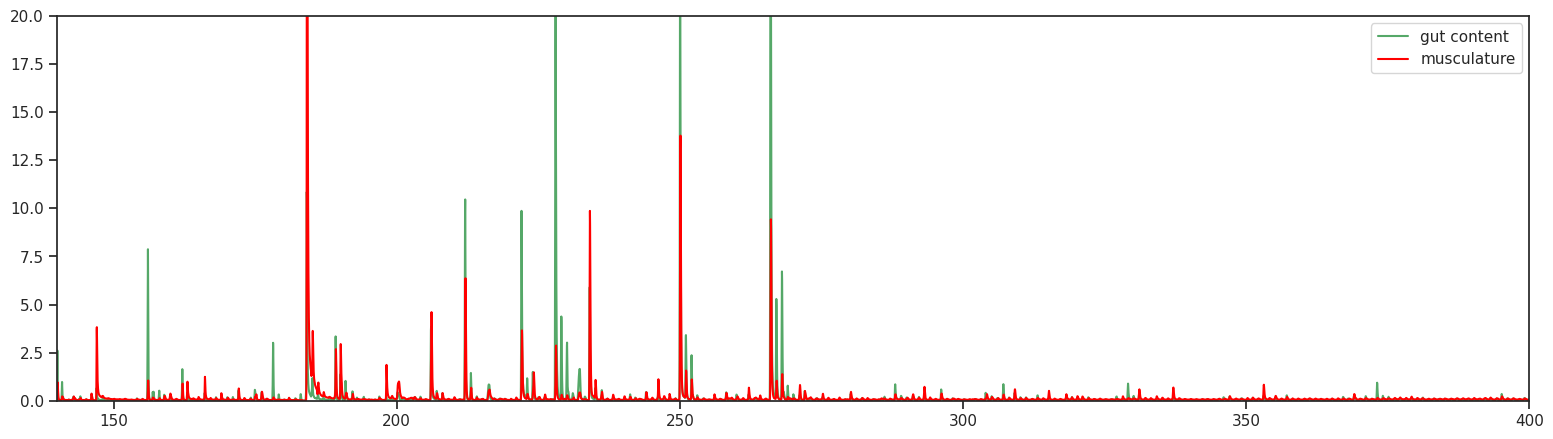

In [37]:
from skimage.morphology import closing, remove_small_objects, remove_small_holes
import matplotlib.pyplot as plt

# min max and apply threshold
MUSC_mask = MinMaxNorm(MUSC[0]) > 0.1
CONT_mask = MinMaxNorm(CONT[0]) > 0.15

# morphological operations to improve mask
MUSC_mask = remove_small_holes(remove_small_objects(closing(MUSC_mask)))
CONT_mask = remove_small_objects(remove_small_holes(closing(CONT_mask)))

# get the actual indices of the pixels under the mask using the index image
CONT_indices = IDX[0][CONT_mask > 0].flatten()
MUSC_indices = IDX[0][MUSC_mask > 0].flatten()

# get all spectra for the given indices
CONT_spectra = I.GetSpectra(CONT_indices)
MUSC_spectra = I.GetSpectra(MUSC_indices)

# get the m/z axis
xs = I.GetXAxis()

# create the mean spectra for musculature and gut content
cont_mean_spectrum = np.mean(CONT_spectra,axis=0)
musc_mean_spectrum = np.mean(MUSC_spectra,axis=0)


# plot the results
fig,_ = showimg(MUSC[0], cmap='viridis', title='musculature (m/z 1088.868±0.249 Da)'  , subplot_pos=(2,3,1), size=(19,10))
fig,_ = showimg(MUSC_mask,  cmap='viridis', title='musculature mask',  subplot_pos=(2,3,2), fig=fig)
fig,_ = showimg(CONT[0], cmap='viridis', title='gut content (m/z 177.919±0.2 Da)'  , subplot_pos=(2,3,4), fig=fig)
fig,_ = showimg(CONT_mask,   cmap='viridis', title='gut content mask', subplot_pos=(2,3,5), fig=fig)

ax = fig.add_subplot(2,3,3)
ax.plot(I.GetXAxis(), np.mean(CONT_spectra,axis=0), 'g')
ax.plot(I.GetXAxis(), np.mean(MUSC_spectra,axis=0), 'r')
ax.annotate('m/z 1088.868±0.249 Da ',xy=(1088.868,0.45),xytext=(1088.868,0.6),arrowprops={})
plt.xlim([1078,1098])
plt.ylim([0,1])


red_patch = mpatches.Patch(color='red', label='musculature')
ax.legend(handles=[red_patch])
green_patch = mpatches.Patch(color='green', label='gut content')
ax.legend(handles=[red_patch])
leg = ax.legend(handles = [red_patch, green_patch],loc='upper left', fontsize=10)

ax = fig.add_subplot(2,3,6)


ax.plot(xs, cont_mean_spectrum, 'g')
ax.plot(xs, musc_mean_spectrum, 'r')
ax.annotate('m/z 177.919±0.2 Da ',xy=(178.119,3.0),xytext=(178.119,3.6),arrowprops={})

plt.xlim([172,183])
plt.ylim([0,4])


red_patch = mpatches.Patch(color='red', label='musculature')
ax.legend(handles=[red_patch])
green_patch = mpatches.Patch(color='green', label='gut content')
ax.legend(handles=[red_patch])
leg = ax.legend(handles = [red_patch, green_patch],loc='upper left', fontsize=10)

fig.tight_layout()

plt.figure(figsize=(19,5))
plt.plot(xs, cont_mean_spectrum, label="gut content", c='g')
plt.plot(xs, musc_mean_spectrum, label="musculature", c='red')
plt.xlim((140,400))
plt.ylim((0,20))
plt.legend()
